# Training with quantized weights

We are interested in training on quantized weights and testing the limits in terms of precision.
We explore different training metaparameters, such as:
* Bitwidth
* Learning rate
* Batch size
* Momentum
* Stochastic / deterministic quantization
* Choice of optimizer

In order to test quantization, while still using conventional libraries and GPUs, we write a Keras callback function, which quantizes the weights after every batch. Since there is only one weight update per batch, the weights are quantized all the time.

In [61]:
from __future__ import print_function

import cPickle as pickle
import numpy as np
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
import keras.backend as K

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import seaborn as sns

from quantize import *

%matplotlib notebook
%load_ext autoreload
%autoreload 2

def save_object(data, filename):
    with open(filename, 'wb') as output:
        pickle.dump(data, output, pickle.HIGHEST_PROTOCOL)
        
        
def load_object(filename):
    try:
        with open(filename, 'rb') as input:
            return pickle.load(input)
    except Exception as err: 
        print(err)
        return None

            
def build_model():
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(784,)))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='softmax'))
    return model


def get_mnist():
    # the data, shuffled and split between train and test sets
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    x_train = x_train.reshape(60000, 784)
    x_test = x_test.reshape(10000, 784)
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    #print(x_train.shape[0], 'train samples')
    #print(x_test.shape[0], 'test samples')

    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, 10)
    y_test = keras.utils.to_categorical(y_test, 10)
    
    return x_train, y_train, x_test, y_test

    
x_train, y_train, x_test, y_test = get_mnist()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# We first check the distribution of weights after 10 epochs of full precision training. We determine the range they inhabit, and quantize that range to $2^b$ values where $b$ is the bitwidth

## We can see that the majority of weights is in the [-0.1, 0.1] range, so we quantize that.

<IPython.core.display.Javascript object>


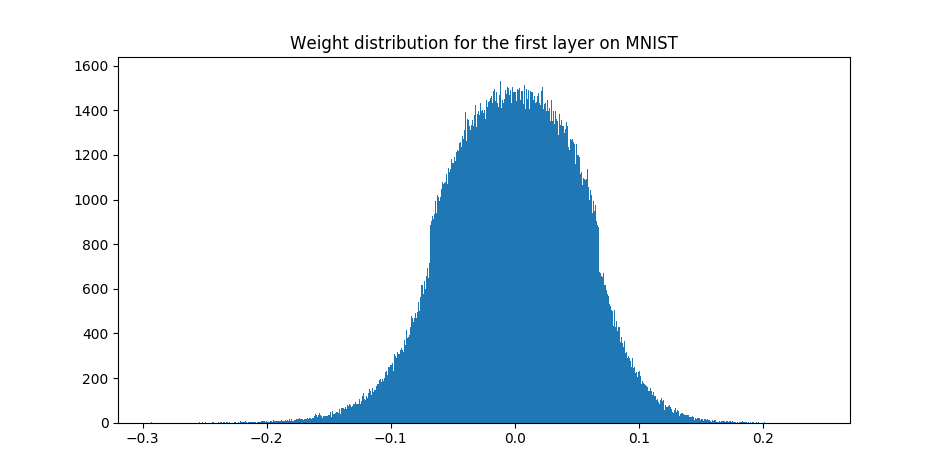

In [62]:
epochs = 10
batch_size = 512
lr = 0.001

model = build_model()
model.compile(loss='categorical_crossentropy',
          optimizer=RMSprop(lr=lr),
          metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    batch_size=batch,
                    epochs=epochs,
                    verbose=0,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
                
weights = [K.get_value(w) for w in model.weights]

plt.title("Weight distribution for the first layer on MNIST")

_ = plt.hist(weights[0].flatten(), bins=1000)


# We test 3 different models:
* 32bit floating point model
* Deterministicly quantized 8bit model
* Stochastically quantized 8bit model
* Deterministicly quantized 4bit model
* Stochastically quantized 4bit model

## Stochastic quantization
The stochastic quantization does not round the value to the nearest tick, but instead randomly chooses between the upper and lower tick, with closeness determining the probability 

## Zeroless stochastic quantization
For the simple quantization implementation, with $b$ bits we can quantize values to the range $[-2^{b-1}, 2^{b-1}-1]$

Here we try out also quantizing to $[-2^{b-1}, 2^{b-1}] / \{0\}$


<IPython.core.display.Javascript object>


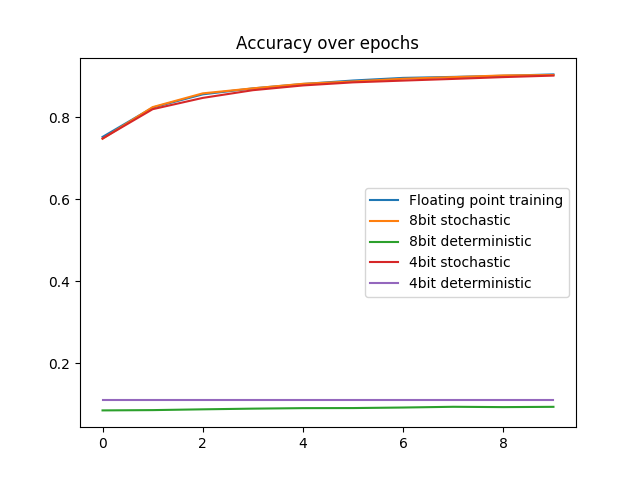

In [84]:
epochs = 10
batches = 512

histories = load_object("data/model_comparison.pickle")
if histories is None:
    models = [build_model() for x in range(5)]
    optimizer = SGD(momentum=0.0)
    histories = []

    for model in models:
        model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    print("Training model with bitwidth {} and stochastic {}".format(bw, stochastic))
    fp_history = model.fit(x_train, y_train, batch_size=batches, epochs=epochs, verbose=1, validation_data=(x_test, y_test))
    histories.append(fp_history.history) 

    for model, bw, stochastic in zip(models, [8, 8, 4, 4], [True, False, True, False]):
        print("Training model with bitwidth {} and stochastic {}".format(bw, stochastic))
        history = model.fit(x_train, y_train, batch_size=batches, epochs=epochs, verbose=1, validation_data=(x_test, y_test),
            callbacks=[RangeQuantizeCallback(fraction_bits=bw, scale=10, stochastic=stochastic)])
        histories.append(history.history)
        
    save_object(histories, "data/model_comparison.pickle")

    
plots = [plt.plot(hist['val_acc'])[0] for hist in histories]
    
plt.title("Accuracy over epochs")
plt.legend(plots, ["Floating point training", "8bit stochastic", "8bit deterministic", "4bit stochastic", "4bit deterministic"])

# As we can see, quantized networks train perfectly well as long as we stochastically quantize them! The deterministic ones do no train at all apparently.


# Now lets test out how bitwidth and batch size impact accuracy

<IPython.core.display.Javascript object>


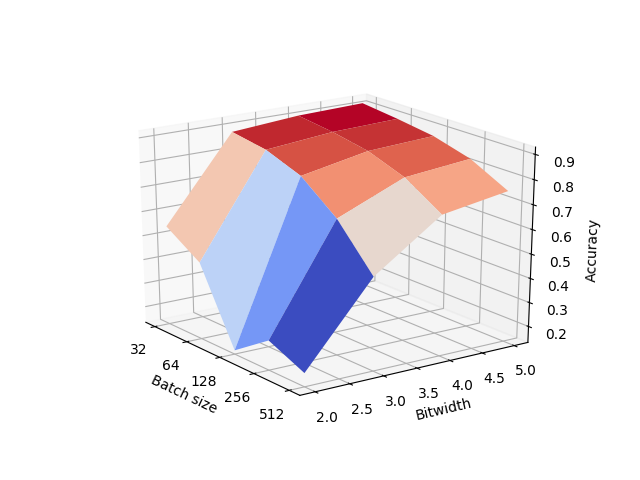

In [50]:
from keras.optimizers import *

epochs = 1
fractions = list(reversed(range(2, 5+1)))
batch_sizes = list(reversed([32, 64, 128, 256, 512]))
#learning_rates = list([1 / 2.0**x for x in range(0, 5)])
learning_rates = [0.01]
stochastic=True

model = build_model()
optimizer = SGD(momentum=0.0)
model.compile(loss='categorical_crossentropy',
          optimizer=optimizer,
          metrics=['accuracy'])

histories = load_object("data/batch_bitwidth_grid.pickle")
if histories is None:
    histories = []
    for batch in batch_sizes:
        for lr in learning_rates:
            for fraction_bits in fractions:
                np.random.seed(0xdeadbeef)

                reinit_weights(model)
                K.set_value(optimizer.lr, lr)
                
                print("Running training for fraction {}, learning rate {}".format(fraction_bits, lr))
                history = model.fit(x_train, y_train,
                                    batch_size=batch,
                                    epochs=epochs,
                                    verbose=1,
                                    validation_data=(x_test, y_test),
                                    callbacks=[RangeQuantizeCallback(fraction_bits=fraction_bits, scale=10, stochastic=stochastic)])
                score = model.evaluate(x_test, y_test, verbose=0)
                print("Test accuracy: {}".format(score[1]))

                histories.append({'hist': history.history, 'lr': lr, 'batch': batch, 'fraction':fraction_bits})
                
    save_object(histories, "data/batch_bitwidth_grid.pickle")
    

shape = (len(batch_sizes), len(fractions))
x = np.log2(np.array([entry['batch'] for entry in histories]).reshape(shape))
y = np.array([entry['fraction'] for entry in histories]).reshape(shape)
acc = np.array([entry['hist']['val_acc'] for entry in histories]).reshape(shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

plt.xticks(np.log2(batch_sizes), batch_sizes)
ax.set_xlabel("Batch size")
ax.set_ylabel("Bitwidth")
ax.set_zlabel("Accuracy")

_ = ax.plot_surface(x, y, acc, cmap=cm.coolwarm, linewidth=1, antialiased=True)

## It seems that the batch size does not significantly impact training quantized nets. Still, we want smaller batches if possible.

Training time for a batch is inversely proportional with the batch size - double the batch, halve the training time. That is a bit unfortunate, unless we could push the model to be computationally bound.

# Now lets check how learning rate and bitwidth interact for simple quantization and zeroless quantization

<IPython.core.display.Javascript object>


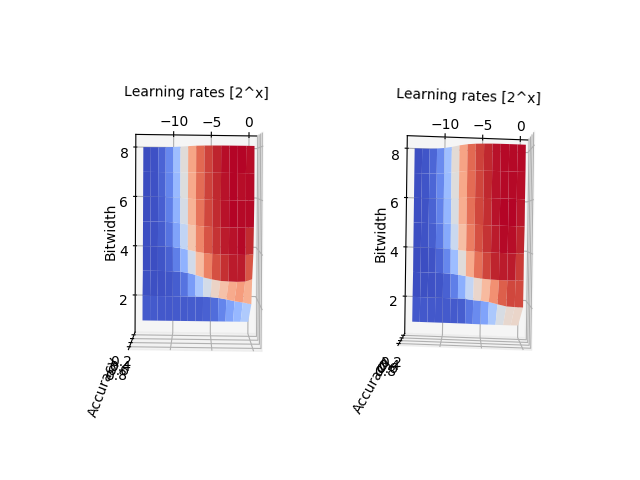

In [121]:
from keras.optimizers import *

epochs = 1
fractions = list(reversed(range(1, 8+1)))
#batch_sizes = list(reversed([32, 64, 128, 256, 512]))
batch_sizes = [512]
learning_rates = list([1 / 2.0**x for x in range(0, 15)])
#learning_rates = [0.01]
stochastic=True

model = build_model()
optimizer = SGD(momentum=0.0)
model.compile(loss='categorical_crossentropy',
          optimizer=optimizer,
          metrics=['accuracy'])

histories = load_object("data/lr_bitwidth_grid.pickle")
if histories is None:
    histories = []
    for batch in batch_sizes:
        for lr in learning_rates:
            for fraction_bits in fractions:
                np.random.seed(0xdeadbeef)

                reinit_weights(model)
                K.set_value(optimizer.lr, lr)
                
                print("Running training for fraction {}, learning rate {}".format(fraction_bits, lr))
                history = model.fit(x_train, y_train,
                                    batch_size=batch,
                                    epochs=epochs,
                                    verbose=1,
                                    validation_data=(x_test, y_test),
                                    callbacks=[RangeQuantizeCallback(fraction_bits=fraction_bits, scale=10, stochastic=stochastic, zeros=True)])
                score = model.evaluate(x_test, y_test, verbose=0)
                print("Test accuracy: {}".format(score[1]))

                histories.append({'hist': history.history, 'lr': lr, 'batch': batch, 'fraction':fraction_bits})
                
    save_object(histories, "data/lr_bitwidth_grid.pickle")
    
    
no_zero_histories = load_object("data/zeroless_lr_bitwidth_grid.pickle")
if no_zero_histories is None:
    no_zero_histories = []
    for batch in batch_sizes:
        for lr in learning_rates:
            for fraction_bits in fractions:
                np.random.seed(0xdeadbeef)

                reinit_weights(model)
                K.set_value(optimizer.lr, lr)
                
                print("Running training for fraction {}, learning rate {}".format(fraction_bits, lr))
                history = model.fit(x_train, y_train,
                                    batch_size=batch,
                                    epochs=epochs,
                                    verbose=1,
                                    validation_data=(x_test, y_test),
                                    callbacks=[RangeQuantizeCallback(fraction_bits=fraction_bits, scale=10, stochastic=stochastic, zeros=False)])
                score = model.evaluate(x_test, y_test, verbose=0)
                print("Test accuracy: {}".format(score[1]))

                no_zero_histories.append({'hist': history.history, 'lr': lr, 'batch': batch, 'fraction':fraction_bits})
                
    save_object(no_zero_histories, "data/zeroless_lr_bitwidth_grid.pickle")
    

shape = (len(learning_rates), len(fractions))
x = np.log2(np.array([entry['lr'] for entry in histories]).reshape(shape))
y = np.array([entry['fraction'] for entry in histories]).reshape(shape)
acc = np.array([entry['hist']['val_acc'] for entry in histories]).reshape(shape)
x_nz = np.log2(np.array([entry['lr'] for entry in no_zero_histories]).reshape(shape))
y_nz = np.array([entry['fraction'] for entry in no_zero_histories]).reshape(shape)
acc_nz = np.array([entry['hist']['val_acc'] for entry in no_zero_histories]).reshape(shape)

fig = plt.figure()
ax = fig.add_subplot(121, projection='3d')

#plt.xticks(np.log2(learning_rates), np.round(learning_rates, decimals=3))
ax.set_xlabel("Learning rates [2^x]")
ax.set_ylabel("Bitwidth")
ax.set_zlabel("Accuracy")

_ = ax.plot_surface(x, y, acc, cmap=cm.coolwarm, linewidth=1, antialiased=True)

ax = fig.add_subplot(122, projection='3d')

#plt.xticks(np.log2(learning_rates), np.round(learning_rates, decimals=3))
ax.set_xlabel("Learning rates [2^x]")
ax.set_ylabel("Bitwidth")
ax.set_zlabel("Accuracy")

_ = ax.plot_surface(x_nz, y_nz, acc_nz, cmap=cm.coolwarm, linewidth=1, antialiased=True)

# We see that the learning rate has a large impact on accuracy, but is relatively independent of bitwidth. 
## This is unexpected, as we would think that higher bitwidths allow for smaller learning rates.

# Let's quantize the weights on a smaller range!

We try anything from [$-2^{-5}$, $2^{-5}$] to [$-2^5$, $2^5$]

<IPython.core.display.Javascript object>


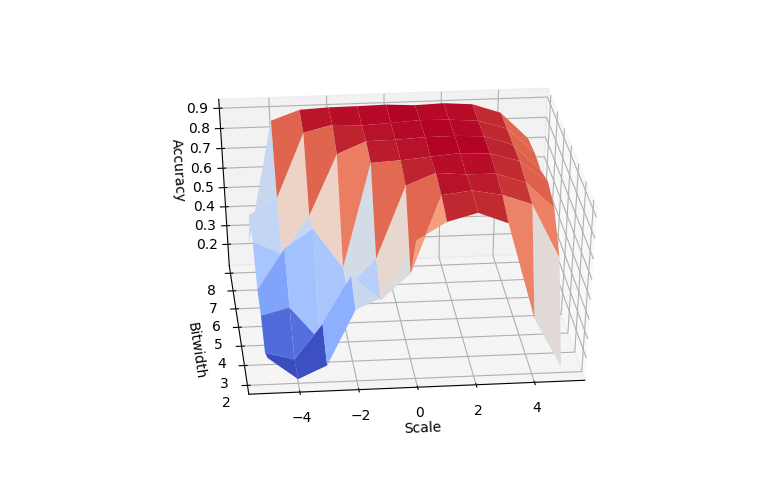

In [112]:
from keras.optimizers import *

epochs = 1
fractions = list(reversed(range(2, 8+1)))
#batch_sizes = list(reversed([32, 64, 128, 256, 512]))
batch_sizes = [512]
#learning_rates = list([1 / 2.0**x for x in range(0, 15)])
learning_rates = [0.25]
scales = [2.0**x for x in range(-5, 5+1)]
stochastic=True

model = build_model()
optimizer = SGD(momentum=0.0)
model.compile(loss='categorical_crossentropy',
          optimizer=optimizer,
          metrics=['accuracy'])

histories = load_object("data/scale_bitwidth_grid.pickle")
if histories is None:
    histories = []
    for batch in batch_sizes:
        for lr in learning_rates:
            for fraction_bits in fractions:
                for scale in scales:
                    np.random.seed(0xdeadbeef)

                    reinit_weights(model)
                    K.set_value(optimizer.lr, lr)

                    print("Running training for fraction {}, scale {}".format(fraction_bits, scale))
                    history = model.fit(x_train, y_train,
                                        batch_size=batch,
                                        epochs=epochs,
                                        verbose=1,
                                        validation_data=(x_test, y_test),
                                        callbacks=[RangeQuantizeCallback(fraction_bits=fraction_bits, scale=scale, stochastic=stochastic)])
                    score = model.evaluate(x_test, y_test, verbose=0)
                    print("Test accuracy: {}".format(score[1]))

                    histories.append({'hist': history.history, 'lr': lr, 'batch': batch, 'fraction':fraction_bits, 'scale':scale})

    save_object(histories, "data/scale_bitwidth_grid.pickle")
    

shape = (len(fractions), len(scales))
x = np.log2(np.array([entry['scale'] for entry in histories]).reshape(shape))
y = np.array([entry['fraction'] for entry in histories]).reshape(shape)
acc = np.array([entry['hist']['val_acc'] for entry in histories]).reshape(shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

#plt.xticks(np.log2(learning_rates), np.round(learning_rates, decimals=3))
ax.set_xlabel("Scale")
ax.set_ylabel("Bitwidth")
ax.set_zlabel("Accuracy")

_ = ax.plot_surface(x, y, acc, cmap=cm.coolwarm, linewidth=1, antialiased=True)

# Seems like the choice of the range we constrain our values does not matter, as long as it is smaller than the range values would naturally fall into ([-0.1, 0.1]). 

# We can see that for lower bitwidths, the range is increasingly more important! That is good to know, and is likely the reason why our 2 bit networks did not perform as well.